## Multi-label prediction with Tencent-ML dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

In [3]:
from pathlib import Path

In [4]:
root = Path('/home/jupyter/mendes/data/')
path = root/'tencent-ml-images/data/'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/mendes/data/tencent-ml-images/data')

In [5]:
# path = Config.data_path()/'planet'
# path.mkdir(parents=True, exist_ok=True)
# path

## Multiclassification

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,filename,labels
0,5213_5411407921_5291a99123_o,light visualsignal bodyofwater water thing lan...
1,4063_4525799362_b207d21d57_o,tree woodyplant ligneousplant flower angiosper...
2,2034_1557324960_1ae893fed8_o,vessel watercraft craft vehicle conveyance tra...
3,6080_6071452334_57111b2799_o,clothing articleofclothing vesture wear wearab...
4,3836_14942119048_2ac3b9309a_o,brickwork masonry building edifice structure c...


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [7]:
df['labels'][2]

'vessel watercraft craft vehicle conveyance transport instrumentality instrumentation artifact artefact whole unit object physicalobject boat ship'

In [8]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [9]:
np.random.seed(42)
src = (ImageList.from_csv(path,'train.csv', folder='train2000', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [10]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

In [ ]:
data.show_batch(rows=2, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [11]:
arch = models.resnet50

In [17]:
#partial is a function from python - it ways call accuracy_thresh with the thresh of .2
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


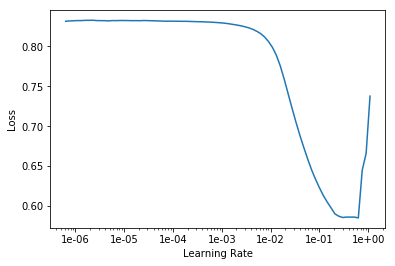

In [14]:
learn.recorder.plot()

Then we can fit the head of our network.

In [15]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.834737,0.721958,0.038449,0.060441,01:56
1,0.707909,0.345050,0.206023,0.068705,01:54
2,0.444082,0.082804,0.985291,0.282878,01:54
3,0.276494,0.060750,0.986149,0.276893,01:52
4,0.186259,0.059105,0.986158,0.276508,01:57


In [19]:
learn.save('stage-2-rn50')

In [20]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [21]:
learn.freeze()

In [22]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 7.43 GiB total capacity; 6.40 GiB already allocated; 27.94 MiB free; 30.61 MiB cached)

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

Private Leaderboard score: 0.9296 (around 80th)